# **Importing Dataset & Libaries**

In [1]:
import sys
sys.path.insert(0,'../src')
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from scipy import stats
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from duckdb_loader import load_mart_data, list_tables, run_query

In [2]:
query = ['SELECT * FROM ' + x  for x in list_tables()] 
tables = [run_query(query[i]) for i in range(len(list_tables()))]
mart_forecast = tables[1]
mart_forecast.info()

<class 'pandas.DataFrame'>
RangeIndex: 23077 entries, 0 to 23076
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   23077 non-null  datetime64[us]
 1   region                 23077 non-null  float64       
 2   instance_type          23077 non-null  str           
 3   year                   23077 non-null  int64         
 4   month                  23077 non-null  int64         
 5   day_of_week            23077 non-null  int64         
 6   week_of_year           23077 non-null  int64         
 7   is_weekend             23077 non-null  int32         
 8   demand                 23077 non-null  float64       
 9   daily_demand_avg       23077 non-null  float64       
 10  daily_demand_max       23077 non-null  float64       
 11  daily_demand_min       23077 non-null  float64       
 12  daily_demand_stddev    22637 non-null  float64       
 13  demand_lag_1

# **Functions**

In [3]:
# PROPHET PATCH - Ver. 2

def fixed_regressor_column_matrix(self, seasonal_features, modes):
    """
    Fixed version of Prophet's regressor_column_matrix method.
    Adds reset_index() to prevent duplicate labels error.
    
    Dataframe indicating which columns of the feature matrix correspond
    to which seasonality/regressor components.
    """
    
    # Create components mapping with NUMERIC indices (not column names)
    components = pd.DataFrame({
        'col': np.arange(seasonal_features.shape[1]),  # [0, 1, 2, 3, ...]
        'component': [
            x.split('_delim_')[0] for x in seasonal_features.columns
        ],
    })
    
    # Add total for holidays
    if self.train_holiday_names is not None:
        components = self.add_group_component(
            components, 'holidays', self.train_holiday_names.unique()
        )
    
    # Add totals for additive and multiplicative components, and regressors
    for mode in ['additive', 'multiplicative']:
        components = self.add_group_component(
            components, mode + '_terms', modes[mode]
        )
        regressors_by_mode = [
            r for r, props in self.extra_regressors.items()
            if props['mode'] == mode
        ]
        components = self.add_group_component(
            components, 'extra_regressors_' + mode, regressors_by_mode
        )
        # Add combination components to modes
        modes[mode].append(mode + '_terms')
        modes[mode].append('extra_regressors_' + mode)
    
    # After all of the additive/multiplicative groups have been added
    modes[self.holidays_mode].append('holidays')
    
    # ========== THE FIX: Reset index to prevent duplicate labels ==========
    components = components.reset_index(drop=True)
    # ======================================================================
    
    # Convert to a binary matrix
    component_cols = pd.crosstab(
        components['col'], components['component'],
    ).sort_index(level='col')
    
    # Add columns for additive and multiplicative terms, if missing
    for name in ['additive_terms', 'multiplicative_terms']:
        if name not in component_cols:
            component_cols[name] = 0
    
    # Remove the placeholder
    component_cols.drop('zeros', axis=1, inplace=True, errors='ignore')
    
    # Validation
    if (max(component_cols['additive_terms']
        + component_cols['multiplicative_terms']) > 1):
        raise Exception('A bug occurred in seasonal components.')
    
    # Compare to the training, if set
    if self.train_component_cols is not None:
        component_cols = component_cols[self.train_component_cols.columns]
        if not component_cols.equals(self.train_component_cols):
            raise Exception('A bug occurred in constructing regressors.')
    
    return component_cols, modes

# Apply the monkey patch
Prophet.regressor_column_matrix = fixed_regressor_column_matrix

print("✓ Prophet patch applied successfully!")

✓ Prophet patch applied successfully!


In [4]:
# ============ MAPE Calculator ============
def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    mask = actual != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

In [5]:
def plot_forecast_comparison(
    ax, dates, y_actual, y_predicted, 
    lower_ci=None, upper_ci=None, mape=None,
    title='Forecast Comparison', xlabel='Date', ylabel='Daily Demand',
    actual_label='Actual', predicted_label='Predicted', ci_label='95% CI'
):
    """
    Renders a forecast comparison plot with actual vs predicted values and optional confidence intervals.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes - Axes object to plot on
    dates : array-like - Dates for x-axis
    y_actual : array-like - Actual values
    y_predicted : array-like - Predicted values
    lower_ci : array-like, optional - Lower confidence interval
    upper_ci : array-like, optional - Upper confidence interval
    mape : float, optional - MAPE value to display in title
    title : str - Plot title
    xlabel : str - X-axis label
    ylabel : str - Y-axis label
    actual_label : str - Label for actual values
    predicted_label : str - Label for predicted values
    ci_label : str - Label for confidence interval
    
    Returns:
    --------
    ax : matplotlib.axes.Axes - The axes object with the plot
    """
    # Plot actual values
    ax.plot(dates, y_actual, label=actual_label, marker='o', 
            linewidth=2, markersize=4, color='#2E86AB', zorder=3)
    
    # Plot predicted values
    ax.plot(dates, y_predicted, label=predicted_label, marker='x', 
            linewidth=2, markersize=4, color='#E63946', zorder=3)
    
    # Plot confidence interval if provided
    if lower_ci is not None and upper_ci is not None:
        ax.fill_between(dates, lower_ci, upper_ci, 
                        alpha=0.2, color='#E63946', label=ci_label, zorder=1)
    
    # Set labels and title
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    
    full_title = f'{title} (MAPE: {mape:.2f}%)' if mape is not None else title
    ax.set_title(full_title, fontsize=14, fontweight='bold', pad=15)
    
    # Add legend and grid
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    return ax

In [6]:
def plot_train_test_split(
    ax, train_dates, train_actual, train_fitted, 
    test_dates, test_actual, test_predicted,
    title='Full Time Series Analysis', xlabel='Date', ylabel='Total Daily Demand'
):
    """
    Renders a full time series plot showing train/test split with fitted and predicted values.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes - Axes object to plot on
    train_dates : array-like - Training dates
    train_actual : array-like - Actual training values
    train_fitted : array-like - Fitted training values
    test_dates : array-like - Test dates
    test_actual : array-like - Actual test values
    test_predicted : array-like - Predicted test values
    title : str - Plot title
    xlabel : str - X-axis label
    ylabel : str - Y-axis label
    
    Returns:
    --------
    ax : matplotlib.axes.Axes - The axes object with the plot
    """
    # Plot training data
    ax.plot(train_dates, train_actual, label='Train (Actual)', 
            color='#95A5A6', alpha=0.6, linewidth=1.5)
    ax.plot(train_dates, train_fitted, label='Train (Fitted)', 
            color='#7F8C8D', alpha=0.8, linewidth=1.5, linestyle='--')
    
    # Plot test data
    ax.plot(test_dates, test_actual, label='Test (Actual)', 
            marker='o', linewidth=2.5, markersize=4, alpha=0.9, color='#2980B9')
    ax.plot(test_dates, test_predicted, label='Test (Predicted)', 
            marker='x', linewidth=2.5, markersize=4, alpha=0.9, color='#E74C3C')
    
    # Add train/test split line
    split_date = train_dates[-1]
    ax.axvline(x=split_date, color='#27AE60', linestyle='--', 
               linewidth=2.5, alpha=0.8, label='Train/Test Split')
    
    # Set labels and title
    ax.set_xlabel(xlabel, fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Add legend and grid
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    return ax

In [7]:
# ============ Metrics Table ============
def plot_performance_table(model_name, ax, mape, mae, rmse, train_len, test_len, total_len):
    """
    Renders a styled performance metrics table on a provided Matplotlib axis.
    """
    ax.axis('tight')
    ax.axis('off')

    metrics_data = [
        ['Metric', 'Value'],
        ['MAPE (%)', f'{mape:.2f}'],
        ['MAE', f'{mae:.2f}'],
        ['RMSE', f'{rmse:.2f}'],
        ['', ''],
        ['Train Size', f'{train_len} days'],
        ['Test Size', f'{test_len} days'],
        ['Total Size', f'{total_len} days']
    ]

    table = ax.table(
        cellText=metrics_data, 
        cellLoc='left', 
        loc='center',
        colWidths=[0.4, 0.4]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.5)

    # Style the header
    for i in range(2):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style metrics rows (MAPE, MAE, RMSE)
    for i in range(1, 4):
        table[(i, 0)].set_facecolor('#F1F1F1')
        table[(i, 1)].set_facecolor('#FFFFFF')

    # Style info rows (Train, Test, Total sizes)
    # Note: index 4 is the empty spacer row
    for i in range(5, 8):
        table[(i, 0)].set_facecolor('#E8E8E8')
        table[(i, 1)].set_facecolor('#F8F8F8')

    ax.set_title(f"{model_name} Model Performance Metrics", fontsize=14, fontweight='bold')
    return ax

# **Prophet Modeling**

20:19:27 - cmdstanpy - INFO - Chain [1] start processing
20:19:27 - cmdstanpy - INFO - Chain [1] done processing


Aggregated to 1088 days from 23077 rows

Train: 870 days | Test: 218 days

Fitting Prophet model...
✓ Model fitted!



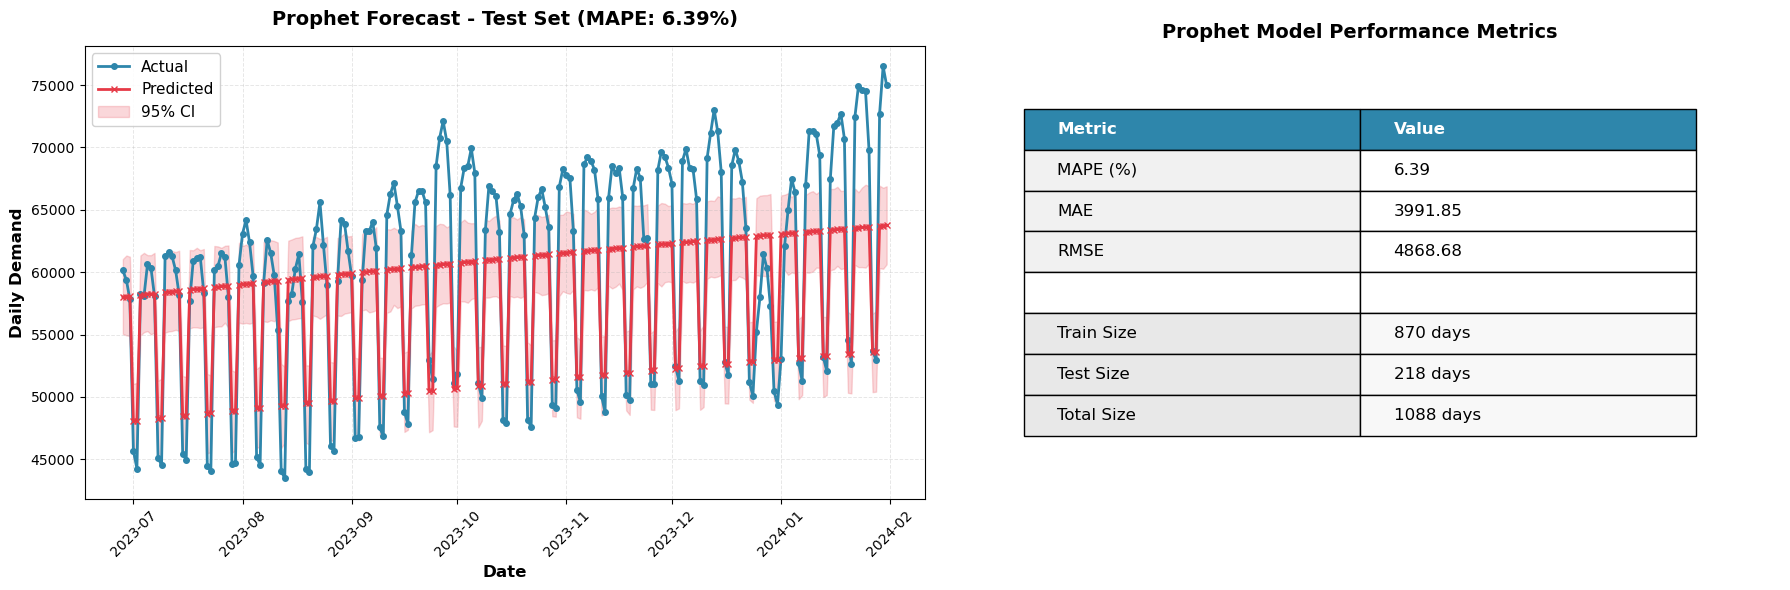

In [8]:
# ============ DATA PREP ============
df_prophet = (
    mart_forecast
    .groupby('date', as_index=False)
    .agg({
        'demand': 'sum',
        'is_weekend': 'first'  
    })
    .rename(columns={'date': 'ds', 'demand': 'y'})
)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)

print(f"Aggregated to {len(df_prophet)} days from {len(mart_forecast)} rows\n")

# Train/test split (80/20)
split_idx = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:split_idx]
test_prophet = df_prophet.iloc[split_idx:]

print(f"Train: {len(train_prophet)} days | Test: {len(test_prophet)} days\n")

# ============ FIT PROPHET ============
print("Fitting Prophet model...")
model_prophet = Prophet()
model_prophet.add_regressor('is_weekend')
model_prophet.fit(train_prophet)
print("✓ Model fitted!\n")

# ============ PREDICT ============
future_prophet = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')
future_prophet['is_weekend'] = future_prophet['ds'].dt.dayofweek.isin([5, 6]).astype(int)
forecast_prophet = model_prophet.predict(future_prophet)

# Extract test predictions
test_pred_prophet = forecast_prophet.tail(len(test_prophet)).reset_index(drop=True)
y_true_prophet = test_prophet['y'].values
y_pred_prophet = test_pred_prophet['yhat'].values

# ============ METRICS ============
mape_prophet = calculate_mape(y_true_prophet, y_pred_prophet)
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))

# ============ VISUALIZATION ============
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Forecast
plot_forecast_comparison(
    ax=axes[0],
    dates=test_prophet['ds'],
    y_actual=y_true_prophet,
    y_predicted=y_pred_prophet,
    lower_ci=test_pred_prophet['yhat_lower'],
    upper_ci=test_pred_prophet['yhat_upper'],
    mape=mape_prophet,
    title='Prophet Forecast - Test Set'
)

# Plot 2: Metrics Table
plot_performance_table('Prophet',axes[1], mape_prophet, mae_prophet, rmse_prophet, len(train_prophet), len(test_prophet), len(df_prophet))
plt.tight_layout()
plt.show()

# **Sarimax Modeling**

Total data points: 1088
Date range: 2021-02-08 00:00:00 to 2024-01-31 00:00:00

Train size: 870 days
Test size: 218 days


✓ SARIMAX model complete!


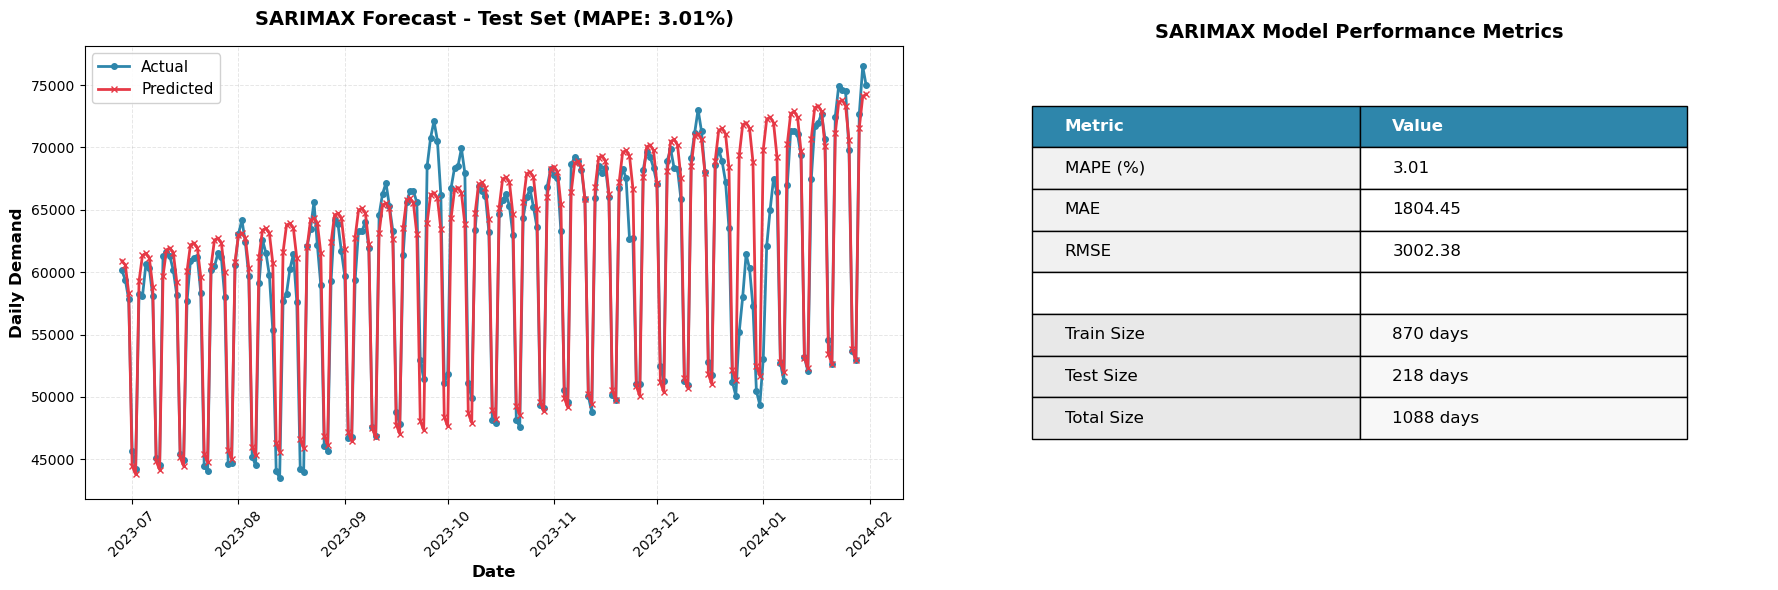

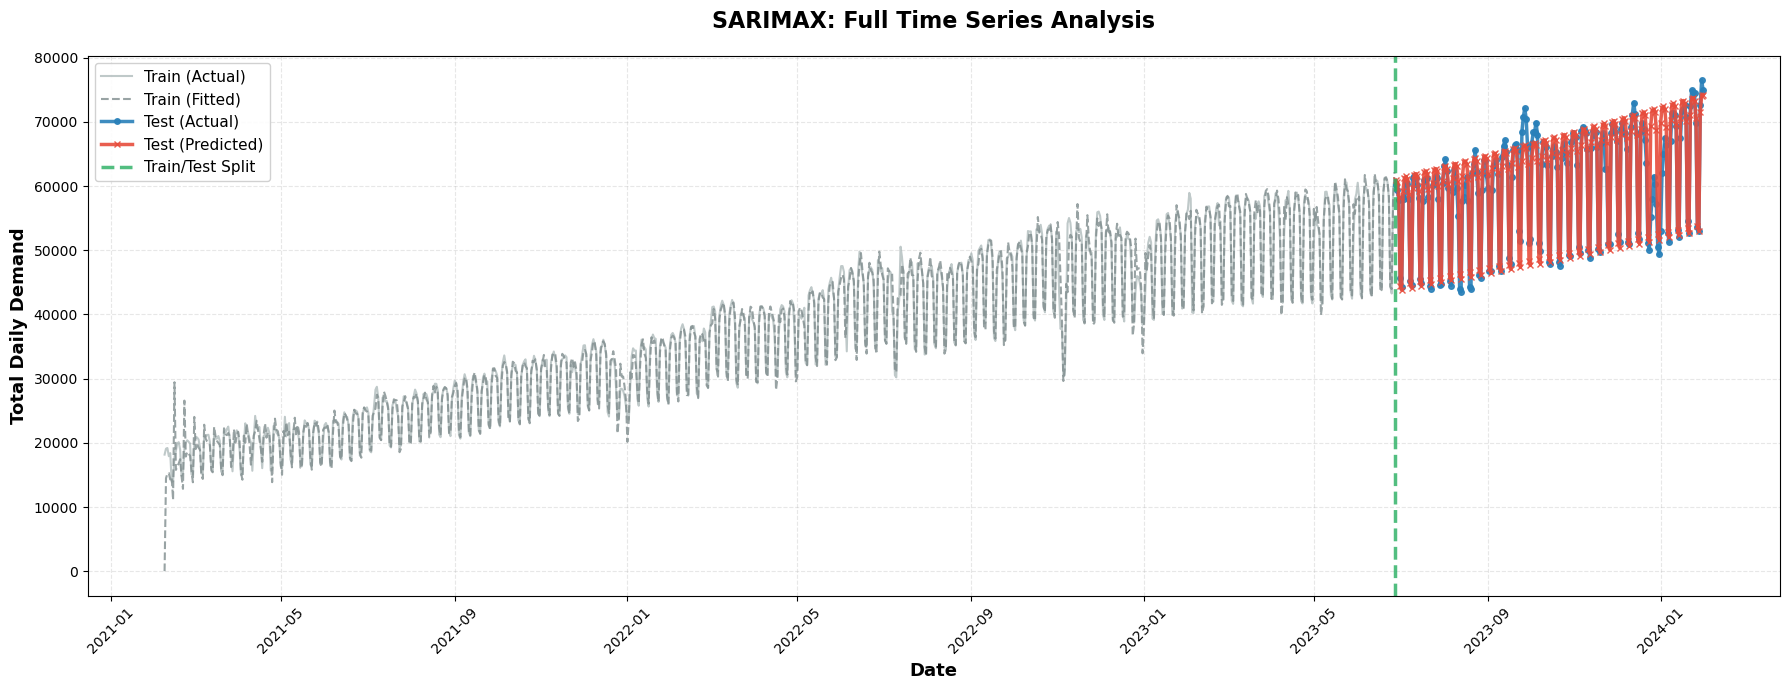

In [9]:
df_sarimax = df_prophet.copy()
df_sarimax.set_index('ds', inplace=True)  

print(f"Total data points: {len(df_sarimax)}")
print(f"Date range: {df_sarimax.index.min()} to {df_sarimax.index.max()}\n")

# ============ TRAIN/TEST SPLIT (80/20) ============
split_idx = int(len(df_sarimax) * 0.8)
train_sarimax = df_sarimax.iloc[:split_idx]['y']
test_sarimax = df_sarimax.iloc[split_idx:]['y']

print(f"Train size: {len(train_sarimax)} days")
print(f"Test size: {len(test_sarimax)} days\n")

# ============ FIT SARIMAX MODEL ============
model_sarimax = SARIMAX(
    train_sarimax,
    order=(1, 0, 0),              # (p,d,q) - autoregressive, differencing, moving average
    seasonal_order=(1, 0, 1, 7),  # (P,D,Q,s) - seasonal components with period=7
    enforce_stationarity=False,
    enforce_invertibility=False,
)

print("\n✓ SARIMAX model complete!")

results_sarimax = model_sarimax.fit(disp=False)

# ============ FORECASTING ============
forecast_sarimax = results_sarimax.forecast(steps=len(test_sarimax))

y_true_sarimax = test_sarimax.values
y_pred_sarimax = forecast_sarimax.values

# ============ CALCULATE METRICS ============
mape_sarimax = calculate_mape(y_true_sarimax, y_pred_sarimax)
mae_sarimax = mean_absolute_error(y_true_sarimax, y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_true_sarimax, y_pred_sarimax))

# ============ VISUALIZATION 1: Test Set + Metrics ============
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Forecast
plot_forecast_comparison(
    ax=axes[0],
    dates=test_sarimax.index,
    y_actual=y_true_sarimax,
    y_predicted=y_pred_sarimax,
    mape=mape_sarimax,
    title='SARIMAX Forecast - Test Set'
)

plt.tight_layout()

# Plot 2: Metrics Table
plot_performance_table('SARIMAX',
                       axes[1], 
                       mape_sarimax, 
                       mae_sarimax, 
                       rmse_sarimax, 
                       len(train_sarimax), 
                       len(test_sarimax), 
                       len(df_sarimax))

# ============ Plot 3: Full Time Series with Train/Test Split ============
fig, ax = plt.subplots(figsize=(18, 7))

plot_train_test_split(
    ax=ax,
    train_dates=train_sarimax.index,
    train_actual=train_sarimax.values,
    train_fitted=results_sarimax.fittedvalues,
    test_dates=test_sarimax.index,
    test_actual=y_true_sarimax,
    test_predicted=y_pred_sarimax,
    title='SARIMAX: Full Time Series Analysis'
)
plt.tight_layout()

plt.show()

# **ETS Modeling**


FITTING TRIPLE ETS (HOLT-WINTERS) MODEL
Train size: 870 days
Test size: 218 days



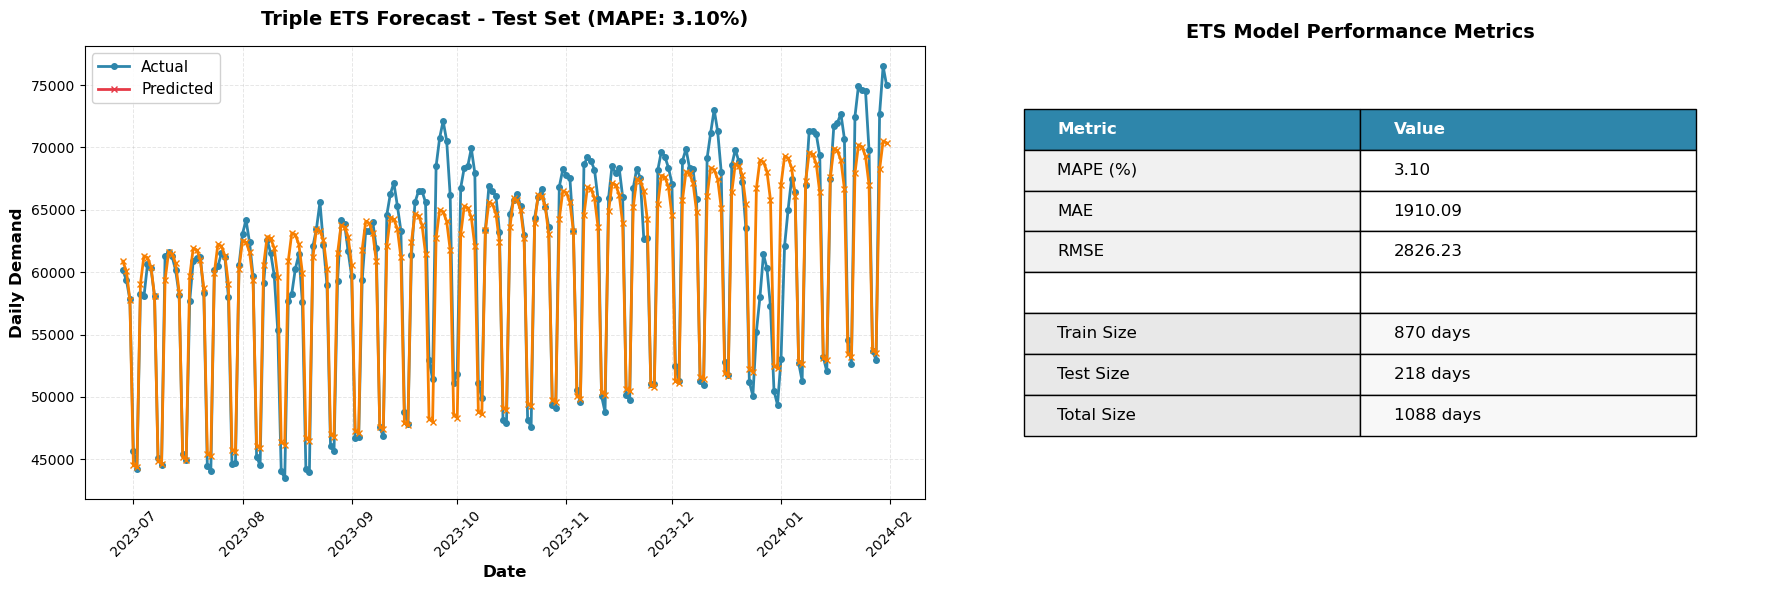

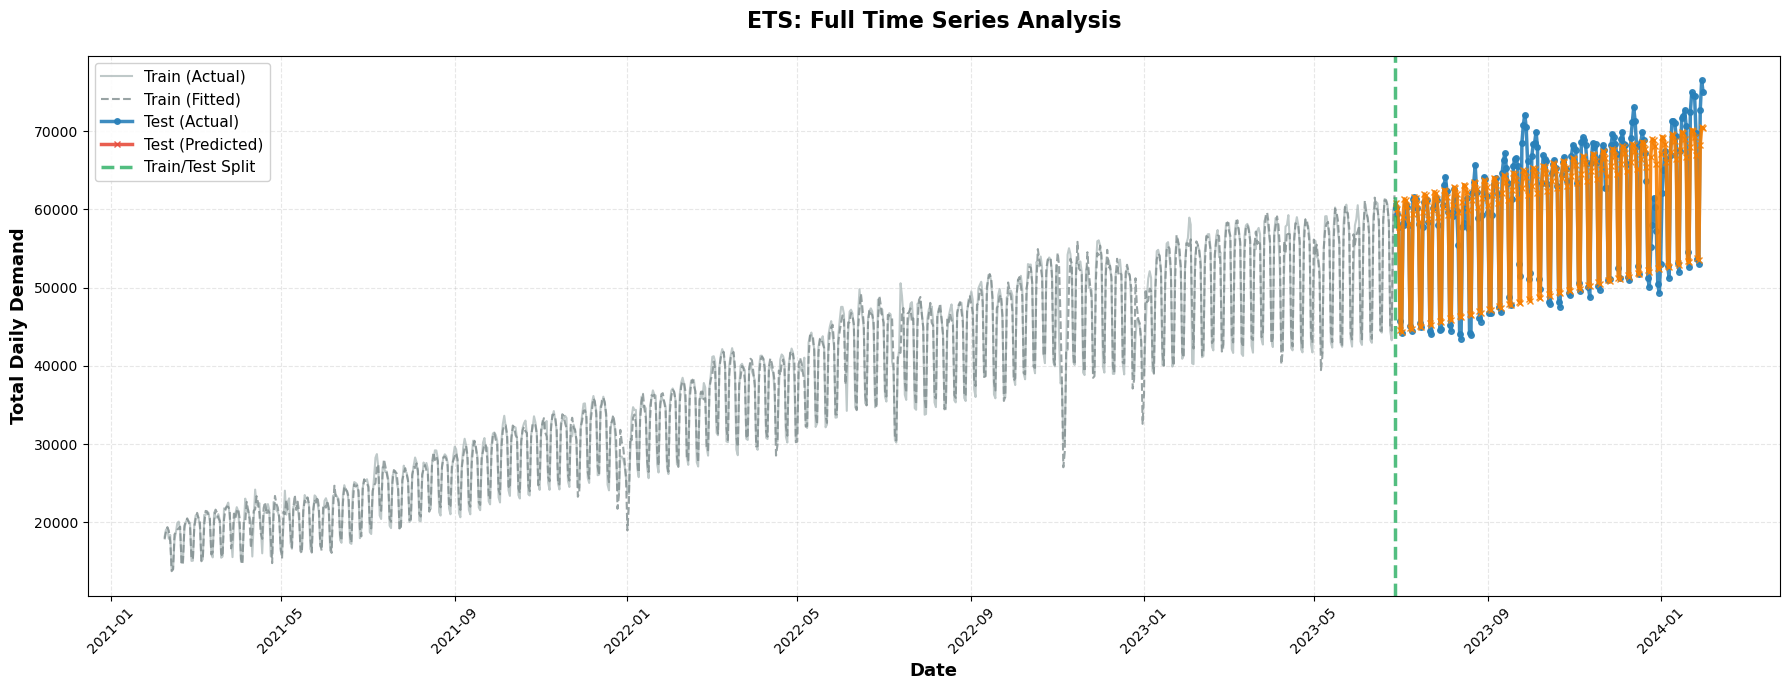


✓ Triple ETS model complete!


In [10]:
print("\n" + "=" * 60)
print("FITTING TRIPLE ETS (HOLT-WINTERS) MODEL")
print("=" * 60)

# ============ PREPARE DATA ============
df_ets = df_prophet.copy()
df_ets.set_index('ds', inplace=True)

# ============ TRAIN/TEST SPLIT (80/20) ============
train_ets = df_ets.iloc[:split_idx]['y']
test_ets = df_ets.iloc[split_idx:]['y']

print(f"Train size: {len(train_ets)} days")
print(f"Test size: {len(test_ets)} days\n")

# ============ FIT TRIPLE ETS MODEL ============
model_ets = ExponentialSmoothing(
    train_ets,
    trend='add',              
    seasonal='add',           
    seasonal_periods=7,      
    damped_trend=False   
)

results_ets = model_ets.fit(optimized=True)

# ============ FORECASTING ============
forecast_ets = results_ets.forecast(steps=len(test_ets))

y_true_ets = test_ets.values
y_pred_ets = forecast_ets.values

# ============ CALCULATE METRICS ============
mape_ets = calculate_mape(y_true_ets, y_pred_ets)
mae_ets = mean_absolute_error(y_true_ets, y_pred_ets)
rmse_ets = np.sqrt(mean_squared_error(y_true_ets, y_pred_ets))

# ============ VISUALIZATION 1: Test Set + Metrics ============
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_forecast_comparison(
    ax=axes[0],
    dates=test_ets.index,
    y_actual=y_true_ets,
    y_predicted=y_pred_ets,
    mape=mape_ets,
    title='Triple ETS Forecast - Test Set',
    predicted_label='Predicted'
)
axes[0].lines[1].set_color('#F77F00')

plot_performance_table(
    'ETS', axes[1], mape_ets, mae_ets, rmse_ets, 
    len(train_ets), len(test_ets), len(df_ets)
)

plt.tight_layout()

# ============ VISUALIZATION 2: Full Time Series with Train/Test Split ============
fig, ax = plt.subplots(figsize=(18, 7))

plot_train_test_split(
    ax=ax,
    train_dates=train_ets.index,
    train_actual=train_ets.values,
    train_fitted=results_ets.fittedvalues,
    test_dates=test_ets.index,
    test_actual=y_true_ets,
    test_predicted=y_pred_ets,
    title='ETS: Full Time Series Analysis'
)

ax.lines[3].set_color('#F77F00')
plt.tight_layout()

plt.show()

print("\n✓ Triple ETS model complete!")

In [11]:
# ============================================================================
# MODEL COMPARISON (ALL THREE MODELS)
# ============================================================================

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"{'Model':<15} {'MAPE (%)':<12} {'MAE':<12} {'RMSE':<12}")
print("-" * 60)
print(f"{'Prophet':<15} {mape_prophet:<12.2f} {mae_prophet:<12.2f} {rmse_prophet:<12.2f}")
print(f"{'SARIMAX':<15} {mape_sarimax:<12.2f} {mae_sarimax:<12.2f} {rmse_sarimax:<12.2f}")
print(f"{'Triple ETS':<15} {mape_ets:<12.2f} {mae_ets:<12.2f} {rmse_ets:<12.2f}")
print("=" * 60)

# ============ DETERMINE BEST MODEL ============
models = {
    'Prophet': mape_prophet,
    'SARIMAX': mape_sarimax,
    'Triple ETS': mape_ets
}

best_model = min(models, key=models.get)
best_mape = models[best_model]

print(f"\n🏆 BEST MODEL: {best_model} (MAPE: {best_mape:.2f}%)")

# Show improvements relative to best model
print("\nRelative Performance (compared to best model):")
for model_name, mape_value in models.items():
    if model_name != best_model:
        diff = mape_value - best_mape
        print(f"  • {model_name}: +{diff:.2f} percentage points worse")

print("=" * 60)


MODEL COMPARISON
Model           MAPE (%)     MAE          RMSE        
------------------------------------------------------------
Prophet         6.39         3991.85      4868.68     
SARIMAX         3.01         1804.45      3002.38     
Triple ETS      3.10         1910.09      2826.23     

🏆 BEST MODEL: SARIMAX (MAPE: 3.01%)

Relative Performance (compared to best model):
  • Prophet: +3.37 percentage points worse
  • Triple ETS: +0.09 percentage points worse


# **Analysis**

PROPHET SEASONALITY ANALYSIS

1. ACTUAL WEEKLY PATTERN:
   Weekday average (Mon-Fri): 65,043
   Weekend average (Sat-Sun): 48,776
   Weekend difference: -16,266 units (-25.0%)
   Pattern type: Weekend DROP (step function)

2. PROPHET'S LEARNED PATTERN:
   Weekly seasonality range: 16 units
   Prophet's weekly effect: -526 to -510
   Predicted weekday avg: 61,032
   Predicted weekend avg: 50,966
   Predicted weekend difference: -10,065 units

3. PATTERN CAPTURE:
   Actual weekend effect: 16,266 units
   Prophet captured: 10,065 units
   Capture rate: 61.9%

4. MAGNITUDE COMPARISON:
   Trend magnitude: 38,222 units
   Actual weekly variation: 18,087 units
   Weekly seasonality range: 16 units
   Trend / Weekly ratio: 2.1x

5. FORECAST ACCURACY:
   Prophet MAPE: 6.39%
   ✓ Good performance - model captured the pattern well


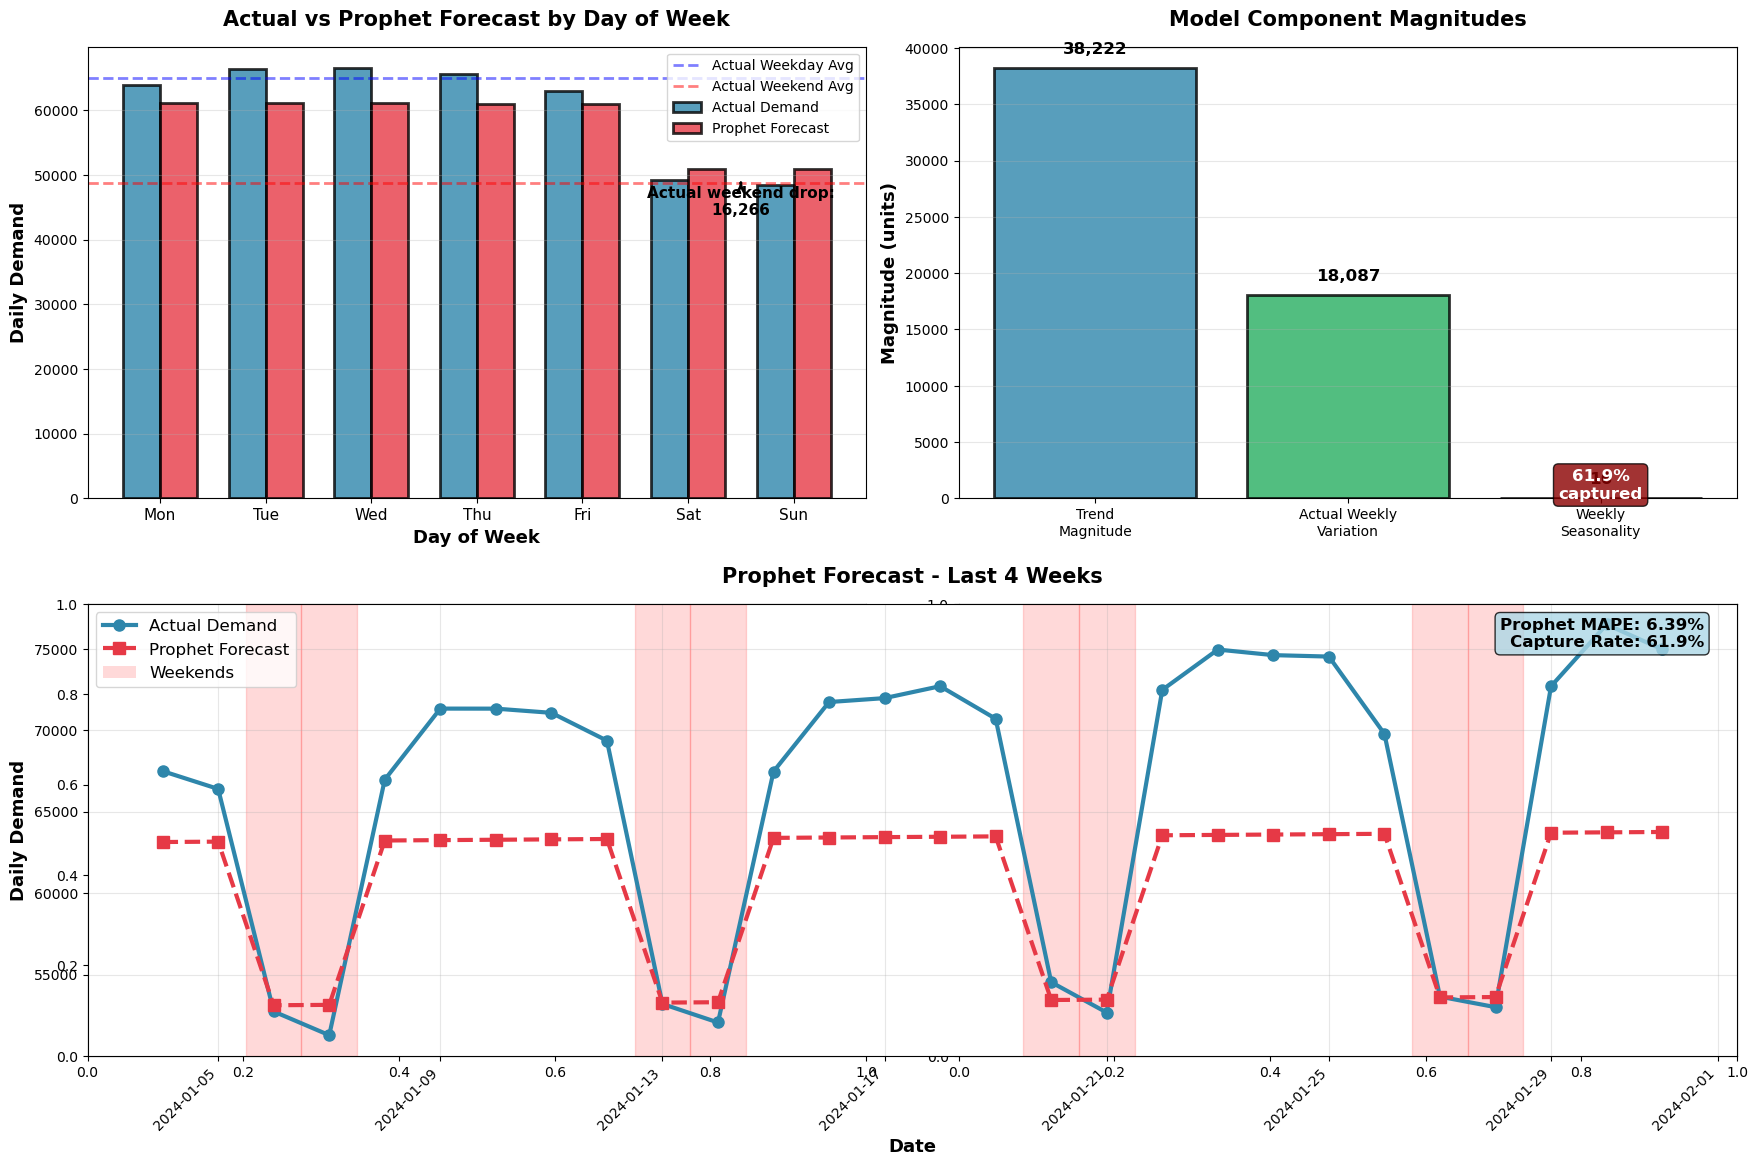


DETAILED DAY-OF-WEEK BREAKDOWN
Day       Actual    Predicted        Error   Error %
Mon 63873.290323 61072.493520  2800.796803  4.384926
Tue 66288.838710 61098.842350  5189.996360  7.829367
Wed 66504.187500 61028.112174  5476.075326  8.234181
Thu 65510.483871 60966.722901  4543.760970  6.935929
Fri 62990.064516 60993.221483  1996.843033  3.170092
Sat 49135.354839 50953.159816 -1817.804978 -3.699587
Sun 48417.645161 50979.582724 -2561.937562 -5.291330



In [12]:
print("=" * 80)
print("PROPHET SEASONALITY ANALYSIS")
print("=" * 80)

# ============================================================================
# ANALYSIS: ACTUAL VS PROPHET'S LEARNED PATTERN
# ============================================================================

# Analyze actual data
test_analysis = test_prophet.copy()
test_analysis['day_of_week'] = test_analysis['ds'].dt.day_name()
test_analysis['day_num'] = test_analysis['ds'].dt.dayofweek
test_analysis['is_weekend_check'] = test_analysis['day_num'].isin([5, 6])

# Calculate actual pattern
days_full = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_short = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

dow_avg = test_analysis.groupby('day_of_week')['y'].mean().reindex(days_full)
weekday_avg = test_analysis[~test_analysis['is_weekend_check']]['y'].mean()
weekend_avg = test_analysis[test_analysis['is_weekend_check']]['y'].mean()

# Extract Prophet's learned pattern
weekly_pattern = forecast_prophet[['ds', 'weekly']].copy()
weekly_pattern['day_of_week'] = weekly_pattern['ds'].dt.day_name()
prophet_weekly = weekly_pattern.groupby('day_of_week')['weekly'].mean().reindex(days_full)

# Calculate magnitudes
actual_range = dow_avg.max() - dow_avg.min()
prophet_weekly_range = prophet_weekly.max() - prophet_weekly.min()
trend_range = forecast_prophet['trend'].max() - forecast_prophet['trend'].min()

# Calculate weekend effect if using is_weekend regressor
test_pred_full = forecast_prophet.tail(len(test_prophet)).reset_index(drop=True)
test_pred_full['ds'] = test_prophet['ds'].values
test_pred_full['is_weekend_check'] = test_pred_full['ds'].dt.dayofweek.isin([5, 6])

# Get predictions by day type
pred_weekday_avg = test_pred_full[~test_pred_full['is_weekend_check']]['yhat'].mean()
pred_weekend_avg = test_pred_full[test_pred_full['is_weekend_check']]['yhat'].mean()

# Print diagnosis
print(f"\n1. ACTUAL WEEKLY PATTERN:")
print(f"   Weekday average (Mon-Fri): {weekday_avg:,.0f}")
print(f"   Weekend average (Sat-Sun): {weekend_avg:,.0f}")
print(f"   Weekend difference: {weekend_avg - weekday_avg:,.0f} units ({(weekend_avg - weekday_avg)/weekday_avg*100:.1f}%)")
if weekend_avg < weekday_avg:
    print(f"   Pattern type: Weekend DROP (step function)")
else:
    print(f"   Pattern type: Weekend RISE (step function)")

print(f"\n2. PROPHET'S LEARNED PATTERN:")
print(f"   Weekly seasonality range: {prophet_weekly_range:.0f} units")
print(f"   Prophet's weekly effect: {prophet_weekly.min():.0f} to {prophet_weekly.max():.0f}")
print(f"   Predicted weekday avg: {pred_weekday_avg:,.0f}")
print(f"   Predicted weekend avg: {pred_weekend_avg:,.0f}")
print(f"   Predicted weekend difference: {pred_weekend_avg - pred_weekday_avg:,.0f} units")

print(f"\n3. PATTERN CAPTURE:")
print(f"   Actual weekend effect: {abs(weekend_avg - weekday_avg):,.0f} units")
print(f"   Prophet captured: {abs(pred_weekend_avg - pred_weekday_avg):,.0f} units")
print(f"   Capture rate: {abs(pred_weekend_avg - pred_weekday_avg) / abs(weekend_avg - weekday_avg) * 100:.1f}%")

print(f"\n4. MAGNITUDE COMPARISON:")
print(f"   Trend magnitude: {trend_range:,.0f} units")
print(f"   Actual weekly variation: {actual_range:,.0f} units")
print(f"   Weekly seasonality range: {prophet_weekly_range:.0f} units")
print(f"   Trend / Weekly ratio: {trend_range / actual_range:.1f}x")

print(f"\n5. FORECAST ACCURACY:")
print(f"   Prophet MAPE: {mape_prophet:.2f}%")
if mape_prophet < 7:
    print(f"   ✓ Good performance - model captured the pattern well")
else:
    print(f"   ⚠️ Could improve - model may be missing some patterns")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# -------------------------------------------------------------------------
# PLOT 1: ACTUAL VS PREDICTED PATTERN (Top Left)
# -------------------------------------------------------------------------
ax1 = axes[0, 0]

x = np.arange(7)
width = 0.35

bars1 = ax1.bar(x - width/2, dow_avg.values, width, label='Actual Demand', 
                color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=2)

# Get predicted values by day of week
pred_by_dow = test_pred_full.copy()
pred_by_dow['day_of_week'] = pred_by_dow['ds'].dt.day_name()
pred_dow_avg = pred_by_dow.groupby('day_of_week')['yhat'].mean().reindex(days_full)

bars2 = ax1.bar(x + width/2, pred_dow_avg.values, width, 
                label='Prophet Forecast', color='#E63946', alpha=0.8, 
                edgecolor='black', linewidth=2)

ax1.axhline(y=weekday_avg, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Actual Weekday Avg')
ax1.axhline(y=weekend_avg, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Actual Weekend Avg')

ax1.set_ylabel('Daily Demand', fontsize=13, fontweight='bold')
ax1.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax1.set_title('Actual vs Prophet Forecast by Day of Week', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(days_short, fontsize=11)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')

# Add annotations
actual_diff = abs(weekend_avg - weekday_avg)
pred_diff = abs(pred_weekend_avg - pred_weekday_avg)
capture_pct = pred_diff / actual_diff * 100 if actual_diff > 0 else 0

if weekend_avg < weekday_avg:
    ax1.annotate(f'Actual weekend drop:\n{actual_diff:,.0f}', 
                xy=(5.5, weekend_avg), xytext=(5.5, weekend_avg - 5000),
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
                fontsize=11, fontweight='bold', ha='center')
else:
    ax1.annotate(f'Actual weekend rise:\n{actual_diff:,.0f}', 
                xy=(5.5, weekend_avg), xytext=(5.5, weekend_avg + 5000),
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
                fontsize=11, fontweight='bold', ha='center')

# -------------------------------------------------------------------------
# PLOT 2: COMPONENT MAGNITUDES (Top Right)
# -------------------------------------------------------------------------
ax2 = axes[0, 1]

components = ['Trend\nMagnitude', 'Actual Weekly\nVariation', 'Weekly\nSeasonality']
magnitudes = [trend_range, actual_range, prophet_weekly_range]
colors = ['#2E86AB', '#27AE60', '#E63946']

bars = ax2.bar(components, magnitudes, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=2)

ax2.set_ylabel('Magnitude (units)', fontsize=13, fontweight='bold')
ax2.set_title('Model Component Magnitudes', 
              fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars, magnitudes)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{val:,.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add capture rate annotation
ax2.text(2, prophet_weekly_range/2, f'{capture_pct:.1f}%\ncaptured', 
         ha='center', fontsize=12, fontweight='bold', color='white',
         bbox=dict(boxstyle='round', facecolor='darkred' if capture_pct < 70 else 'darkgreen', alpha=0.8))

# -------------------------------------------------------------------------
# PLOT 3: LAST 4 WEEKS FORECAST (Bottom, spans both columns)
# -------------------------------------------------------------------------
ax3 = plt.subplot(2, 1, 2)

# Show last 28 days (4 weeks)
last_28_idx = -28
test_28 = test_prophet.iloc[last_28_idx:].copy()
pred_28 = test_pred_prophet.iloc[last_28_idx:].copy()

ax3.plot(test_28['ds'], test_28['y'], 'o-', label='Actual Demand', 
         color='#2E86AB', linewidth=3, markersize=8, zorder=3)
ax3.plot(pred_28['ds'], pred_28['yhat'], 's--', label='Prophet Forecast', 
         color='#E63946', linewidth=3, markersize=8, zorder=3)

# Highlight weekends
for date in test_28['ds']:
    if date.dayofweek in [5, 6]:
        ax3.axvspan(date - pd.Timedelta(hours=12), date + pd.Timedelta(hours=12), 
                    alpha=0.15, color='red', zorder=1)

# Add legend
weekend_patch = plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.15)
ax3.legend([plt.Line2D([0], [0], color='#2E86AB', linewidth=3, marker='o', markersize=8),
            plt.Line2D([0], [0], color='#E63946', linewidth=3, marker='s', 
                      linestyle='--', markersize=8),
            weekend_patch],
           ['Actual Demand', 'Prophet Forecast', 'Weekends'],
           fontsize=12, loc='upper left')

ax3.set_xlabel('Date', fontsize=13, fontweight='bold')
ax3.set_ylabel('Daily Demand', fontsize=13, fontweight='bold')
ax3.set_title('Prophet Forecast - Last 4 Weeks', 
              fontsize=15, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add text box with summary
textstr = f'Prophet MAPE: {mape_prophet:.2f}%\nCapture Rate: {capture_pct:.1f}%'
props = dict(boxstyle='round', facecolor='lightblue' if mape_prophet < 7 else 'wheat', alpha=0.8)
ax3.text(0.98, 0.97, textstr, transform=ax3.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=props,
         fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED BREAKDOWN
# ============================================================================

print("\n" + "=" * 80)
print("DETAILED DAY-OF-WEEK BREAKDOWN")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Day': days_short,
    'Actual': dow_avg.values,
    'Predicted': pred_dow_avg.values,
    'Error': dow_avg.values - pred_dow_avg.values,
    'Error %': ((dow_avg.values - pred_dow_avg.values) / dow_avg.values * 100)
})

print(comparison_df.to_string(index=False))
print("\n" + "=" * 80)